In [2]:
import pandas as pd
import zipfile
import urllib.request
import os

# Download the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip'
urllib.request.urlretrieve(url, 'UCI_HAR_Dataset.zip')

# Extract the ZIP file
with zipfile.ZipFile('UCI_HAR_Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('UCI_HAR_Dataset')

# Define the path to the extracted dataset
dataset_dir = 'UCI_HAR_Dataset/UCI HAR Dataset/'


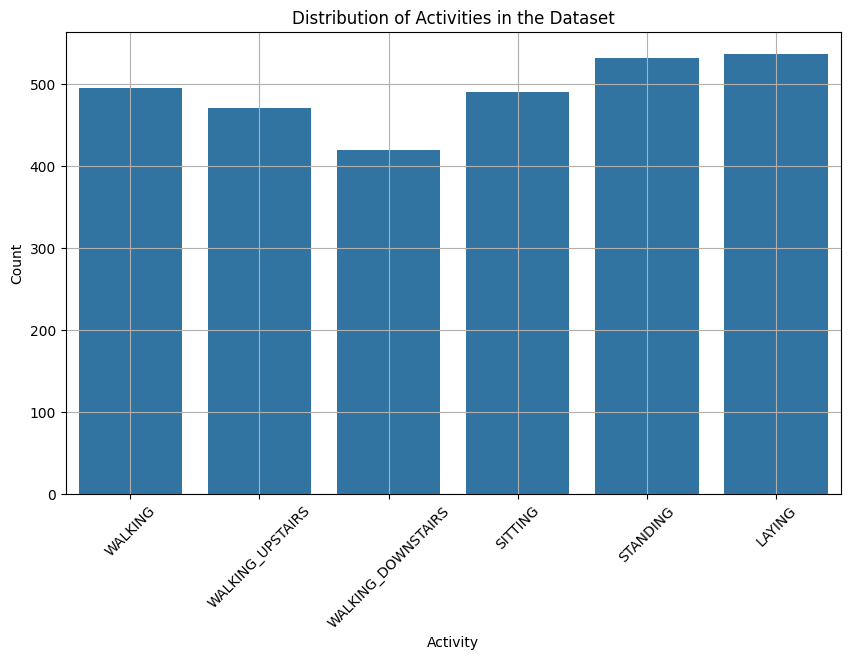

In [16]:
import seaborn as sns

# Visualize the distribution of activities in the training dataset
activity_counts = pd.DataFrame({'Activity': y_true})
activity_counts['Activity'] = activity_counts['Activity'].apply(lambda x: activity_labels['Activity_Label'][x])

plt.figure(figsize=(10, 6))
sns.countplot(data=activity_counts, x='Activity', order=activity_labels['Activity_Label'])
plt.title('Distribution of Activities in the Dataset')
plt.xlabel('Activity')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


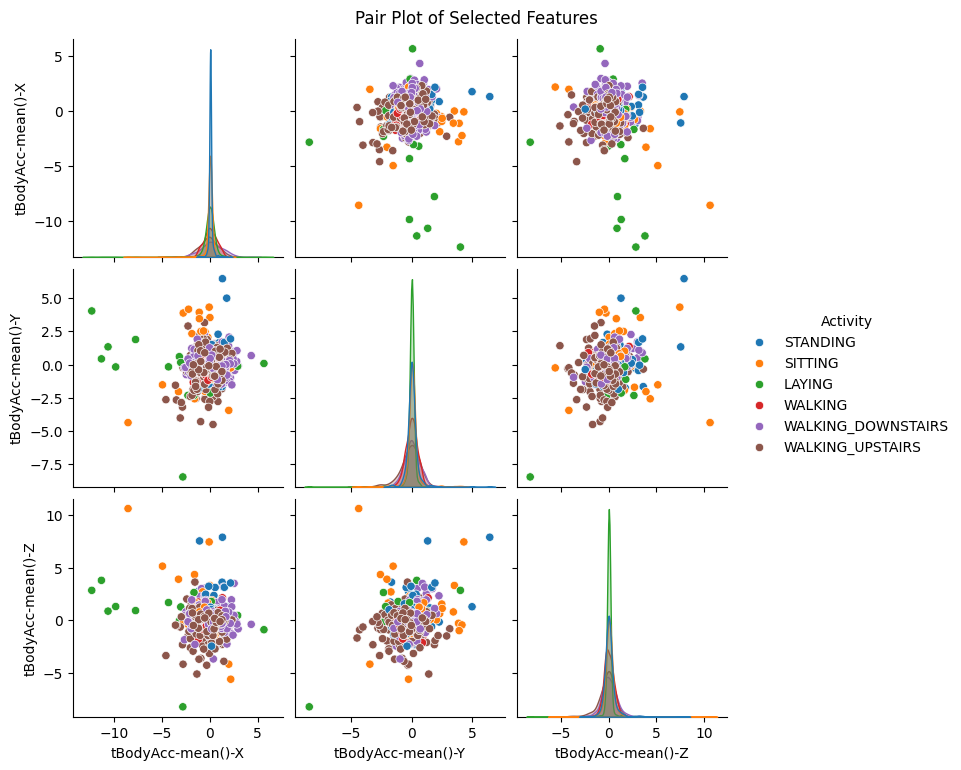

In [17]:
# Convert the test data to a DataFrame for visualization
X_test_df = pd.DataFrame(X_test.reshape(X_test.shape[0], X_test.shape[2]), columns=feature_names)

# Select a few features for pair plotting
selected_features = ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']

# Add the activity labels to the DataFrame
X_test_df['Activity'] = y_true
X_test_df['Activity'] = X_test_df['Activity'].apply(lambda x: activity_labels['Activity_Label'][x])

# Pair plot of selected features
sns.pairplot(X_test_df[selected_features + ['Activity']], hue='Activity', diag_kind='kde')
plt.suptitle('Pair Plot of Selected Features', y=1.02)
plt.show()


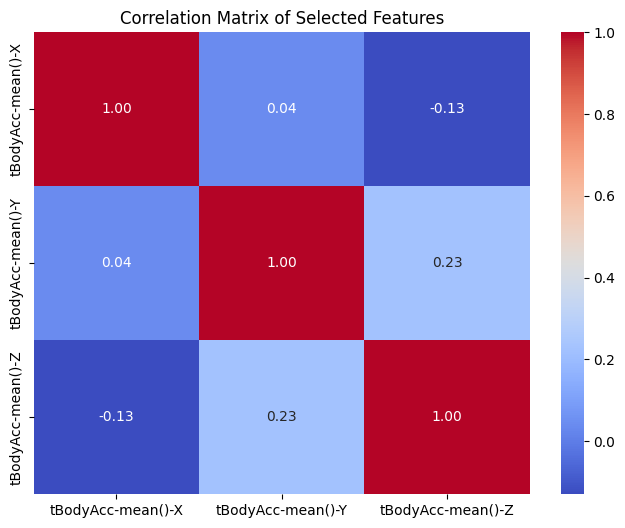

In [18]:
# Compute the correlation matrix
corr_matrix = X_test_df[selected_features].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Selected Features')
plt.show()


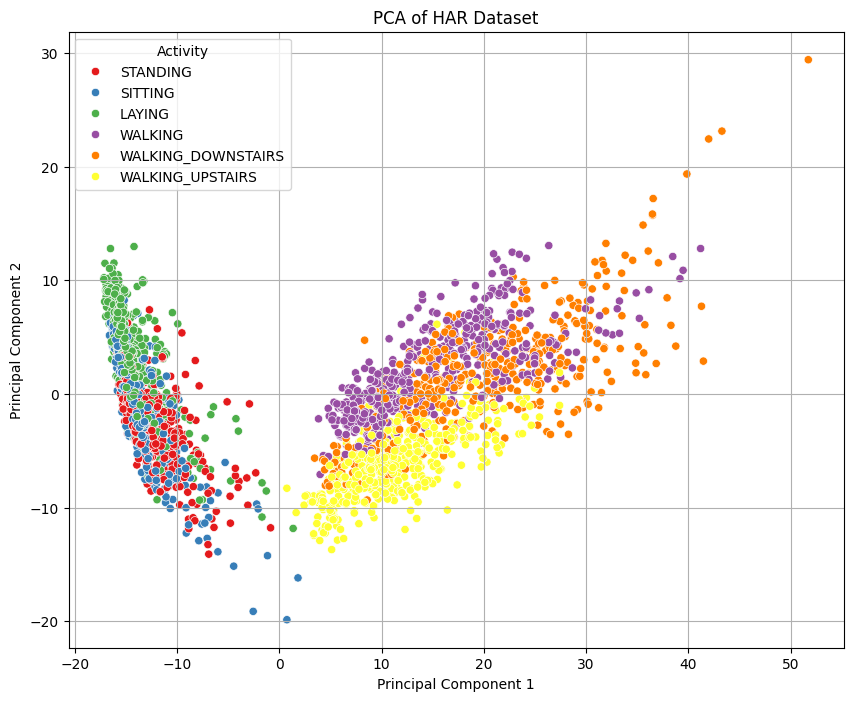

In [20]:
from sklearn.decomposition import PCA

# Apply PCA to reduce the dimensions to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test.reshape(X_test.shape[0], X_test.shape[2]))

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Activity'] = y_true
pca_df['Activity'] = pca_df['Activity'].apply(lambda x: activity_labels['Activity_Label'][x])

# Plot the PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Activity', palette='Set1')
plt.title('PCA of HAR Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()


In [4]:
# Load the feature names
features = pd.read_csv(os.path.join(dataset_dir, 'features.txt'), delim_whitespace=True, header=None)
feature_names = features[1].values

# Load the training data
X_train = pd.read_csv(os.path.join(dataset_dir, 'train/X_train.txt'), delim_whitespace=True, header=None)
X_train.columns = feature_names

y_train = pd.read_csv(os.path.join(dataset_dir, 'train/y_train.txt'), delim_whitespace=True, header=None)

# Load the test data
X_test = pd.read_csv(os.path.join(dataset_dir, 'test/X_test.txt'), delim_whitespace=True, header=None)
X_test.columns = feature_names

y_test = pd.read_csv(os.path.join(dataset_dir, 'test/y_test.txt'), delim_whitespace=True, header=None)

# Optional: Load activity labels
activity_labels = pd.read_csv(os.path.join(dataset_dir, 'activity_labels.txt'), delim_whitespace=True, header=None)
activity_labels.columns = ['Activity_ID', 'Activity_Label']

# Encode the labels (as done previously)
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train.values.ravel())
y_test = encoder.transform(y_test.values.ravel())

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Standardize the features (as done previously)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape input to be 3D [samples, timesteps, features] for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {accuracy:.4f}')


Epoch 1/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6505 - loss: 0.8559 - val_accuracy: 0.9287 - val_loss: 0.1918
Epoch 2/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9417 - loss: 0.1513 - val_accuracy: 0.9189 - val_loss: 0.2185
Epoch 3/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9647 - loss: 0.0983 - val_accuracy: 0.9410 - val_loss: 0.1547
Epoch 4/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9733 - loss: 0.0746 - val_accuracy: 0.9379 - val_loss: 0.1875
Epoch 5/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9684 - loss: 0.0779 - val_accuracy: 0.9403 - val_loss: 0.1666
Epoch 6/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9789 - loss: 0.0598 - val_accuracy: 0.9362 - val_loss: 0.1977
Epoch 7/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9771 - loss: 0.0559 - val_accuracy: 0.9376 - val_loss: 0.2339
Epoch 8/50
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9807 - loss: 0.0473 - val_accuracy: 0

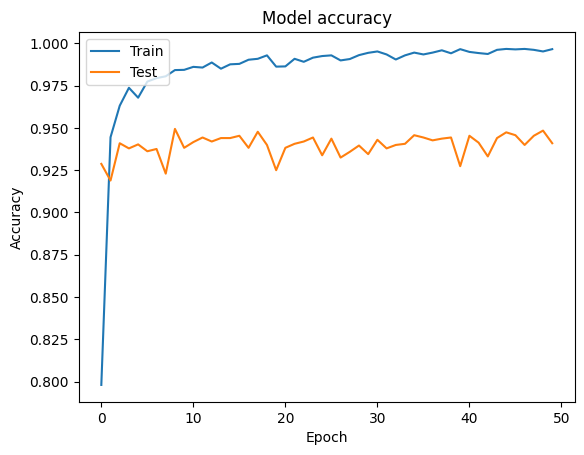

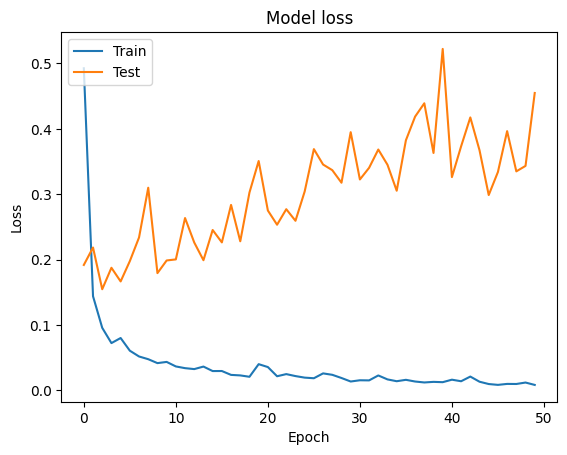

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


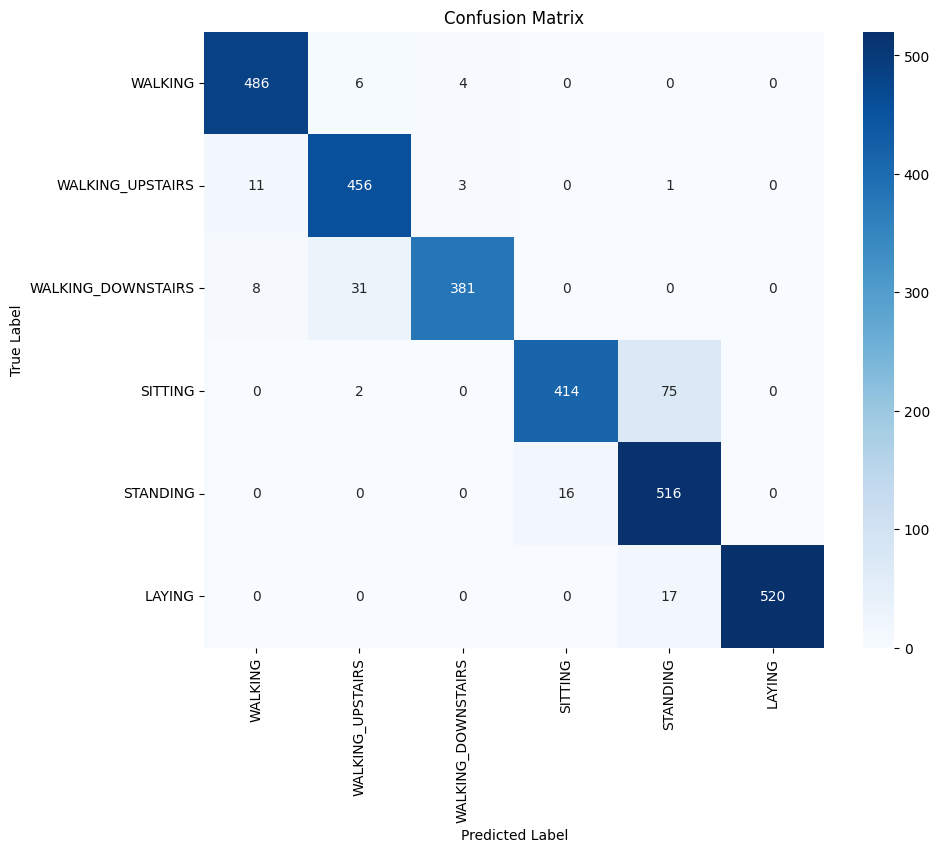

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=activity_labels['Activity_Label'].values, yticklabels=activity_labels['Activity_Label'].values)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [11]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, y_pred_classes, target_names=activity_labels['Activity_Label'].values)
print(report)


                    precision    recall  f1-score   support

           WALKING       0.96      0.98      0.97       496
  WALKING_UPSTAIRS       0.92      0.97      0.94       471
WALKING_DOWNSTAIRS       0.98      0.91      0.94       420
           SITTING       0.96      0.84      0.90       491
          STANDING       0.85      0.97      0.90       532
            LAYING       1.00      0.97      0.98       537

          accuracy                           0.94      2947
         macro avg       0.95      0.94      0.94      2947
      weighted avg       0.94      0.94      0.94      2947



In [12]:
# Display the model architecture
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 50)                  │         122,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             306 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 375,770 (1.43 MB)

 Trainable params: 125,256 (489.28 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 250,514 (978.57 KB)